In [1]:
import math
import numpy as np
import numpy.linalg as npla
from sympy import *
from sympy.plotting import plot
from sympy.plotting.plot import MatplotlibBackend, Plot
import matplotlib
from matplotlib.animation import FuncAnimation 
from IPython import display
import matplotlib.pyplot as plt
import scipy.integrate
import time

In [11]:
# retrieve the first approximated @param stepCnt points with spacing @param h
# formatted as numpy array of shape (3, stepCnt)
# each ith column is the ith point
def getLorenz(w0, t, h, method = "euler"):
    start = time.time()
    stepCnt = int(t / h)-1
    data = np.empty((3, stepCnt + 1))
    data[:, 0] = w0
    
    # lorenz system of ODEs
    # input: array w_i = [x_i, y_i, z_i]
    # output: array dw_i = [dx_i, dy_i, dz_i]
    def lorenz(w):
        return np.array([s*(w[1] - w[0]), r*w[0] - w[1] - w[0]*w[2], w[0]*w[1] - b*w[2]])
    
    # Euler method
    if method == "euler":
        for i in range(stepCnt):
            data[:, i+1] = data[:, i] + lorenz(data[:, i]) * h
            
    # Modified-Euler method
    elif method == "modified_euler":
        for i in range(stepCnt):
            data[:, i+1] = data[:, i] + h/2.0 * (lorenz(data[:, i]) + lorenz(data[:, i] + h*lorenz(data[:, i])))
            
    # Runge-Kutta 4th order method
    elif method == "runge_kutta_4":
        for i in range(stepCnt):
            k1 = h * lorenz(data[:, i])
            k2 = h * lorenz(data[:, i] + k1/2.0)
            k3 = h * lorenz(data[:, i] + k2/2.0)
            k4 = h * lorenz(data[:, i] + k3)
            data[:, i+1] = data[:, i] + (k1 + 2.0*k2 + 2.0*k3 + k4) / 6.0
            
    # Adams-Bashforth multistep method
    # Note that the first 3 initial values are determined using the euler-method
    elif method == "adams_bashforth":
        for i in range(3):
            data[:, i+1] = data[:, i] + lorenz(data[:, i]) * h
        for i in range(3, stepCnt):
            data[:, i+1] = data[:, i] + h/24.0 * (55.0*lorenz(data[:, i]) - 59.0*lorenz(data[:, i-1]) + 37.0*lorenz(data[:, i-2]) - 9.0*lorenz(data[:, i-3]))
    
    # LSODA method that uses Adams/BDF
    # Wrapper for Fortran ODE solver, most precise *easily computable* solution
    elif method == "lsoda":
        tspan = np.linspace(0, stepCnt*h, stepCnt+1)
        sol = scipy.integrate.solve_ivp(lambda t, y: lorenz(y), [tspan[0], tspan[-1]], w0, t_eval=tspan, method = 'LSODA', atol = 1e-10)
        data = sol['y']
    end = time.time()
    totTime = end - start
    return data, totTime

In [12]:
def plotLorenz(w0, t, stepSize, ax, method = "lsoda", c = "blue"):
    lorenz, plotTime = getLorenz(w0, t, stepSize, method)
    start = time.time()
    func, = ax.plot(lorenz[0], lorenz[1], lorenz[2], lw = 0.5, color = c, label = method)
    end = time.time()
    graphTime = end - start
    return lorenz, func, plotTime, graphTime

In [13]:
def compare_lsoda_to_method(t, h, w0, method = "lsoda"):
    %matplotlib inline
    
    r = 28
    s = 10
    b = 8.0/3.0
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(f'Lorenz Attractor (ρ = 28) \n h = {h}, t = {t}')
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    
    steps = int(t/h)
    lorenz0, func0, _, _ = plotLorenz(w0, t, 0.000001, ax, method = "lsoda", c= "red")
    lorenz1, func1, _, _ = plotLorenz(w0, t, h, ax, method = method, c= "blue")
    fp1 = (math.sqrt(b * (r-1)), math.sqrt(b * (r-1)), r-1)
    fp2 = (-math.sqrt(b * (r-1)), -math.sqrt(b * (r-1)), r-1)
    
    ax.scatter(fp1[0], fp1[1], fp1[2], marker='*', color = 'g')
    ax.scatter(fp2[0], fp2[1], fp2[2], marker='*', color = 'g')
    plt.legend()
    plt.show()
    
    plt.title(f'x-values of lsoda and {method} vs. period\nsteps: {steps}, h = {h}')
    plt.xlabel('Period (t)')
    plt.ylabel('x')
    plt.plot(np.linspace(0, t, len(lorenz0[0])), lorenz0[0], c = "r", label = "lsoda")
    plt.plot(np.linspace(0, t, len(lorenz1[0])), lorenz1[0], c = "b", label = method)
    plt.legend()
    plt.show()
    
    plt.title(f'y-values of lsoda and {method} vs. period\nsteps: {steps}, h = {h}')
    plt.xlabel('Period (t)')
    plt.ylabel('y')
    plt.plot(np.linspace(0, t, len(lorenz0[0])), lorenz0[1], c = "r", label = "lsoda")
    plt.plot(np.linspace(0, t, len(lorenz1[0])), lorenz1[1], c = "b", label = method)
    plt.legend()
    plt.show()
    
    plt.title(f'z-values of lsoda and {method} vs. period\nsteps: {steps}, h = {h}')
    plt.xlabel('Period (t)')
    plt.ylabel('z')
    plt.plot(np.linspace(0, t, len(lorenz0[0])), lorenz0[2], c = "r", label = "lsoda")
    plt.plot(np.linspace(0, t, len(lorenz1[0])), lorenz1[2], c = "b", label = method)
    plt.legend()
    plt.show()
    
    plt.title(f'geometric distance between lsoda and {method} vs. period\nsteps: {steps}, h = {h}')
    plt.xlabel('Period (t)')
    plt.ylabel(r'distance ($x^2 + y^2 + z^2$)')
    dist = np.sqrt(np.square(lorenz0[0, ::10000] - lorenz1[0]) + np.square(lorenz0[1, ::10000] - lorenz1[1]) + np.square(lorenz0[2, ::10000] - lorenz1[2]))
    plt.plot(np.linspace(0, t, len(dist)), dist, c = "g")
    plt.show()

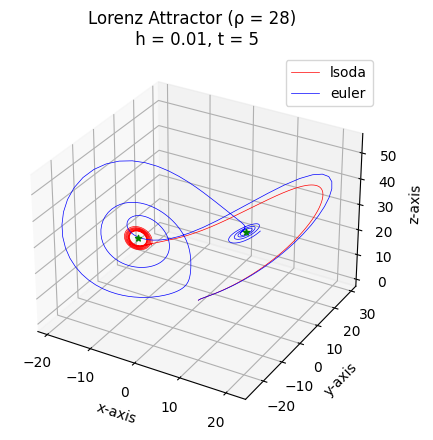

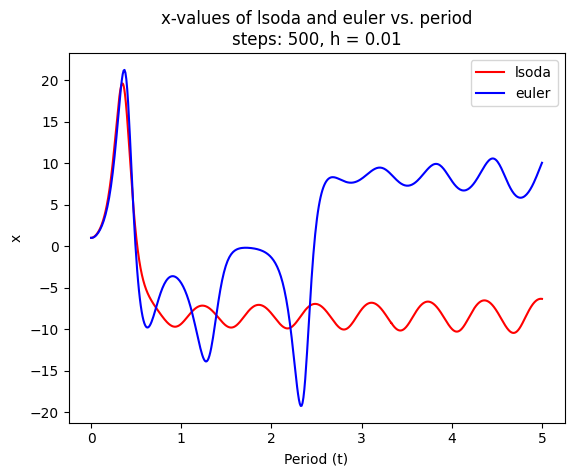

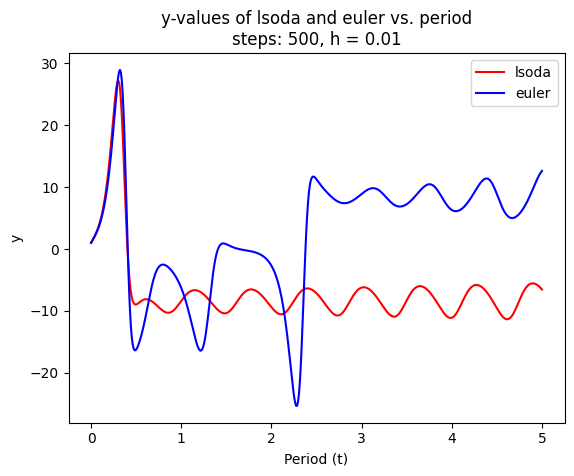

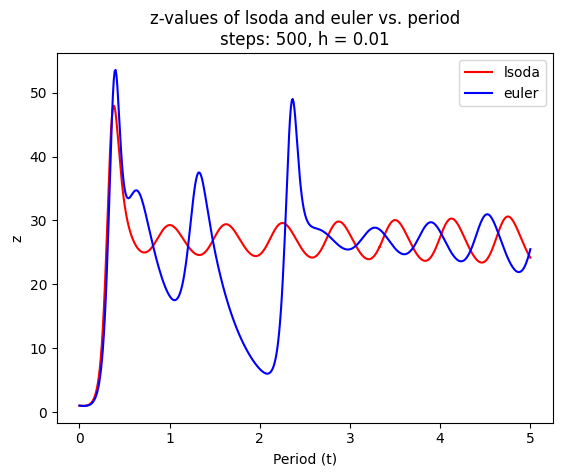

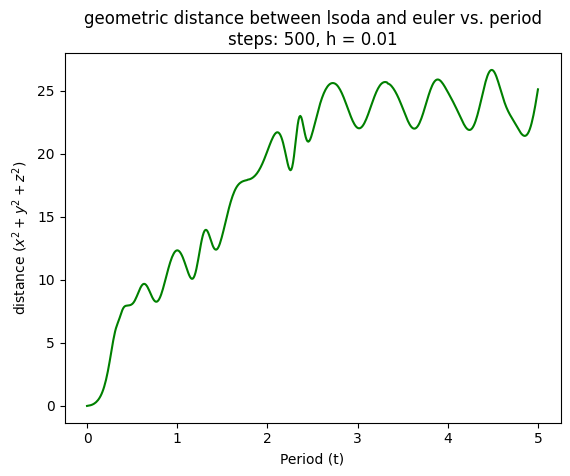

In [14]:
compare_lsoda_to_method(t = 5, h = 0.01, w0 = (1., 1., 1.), method = "euler")

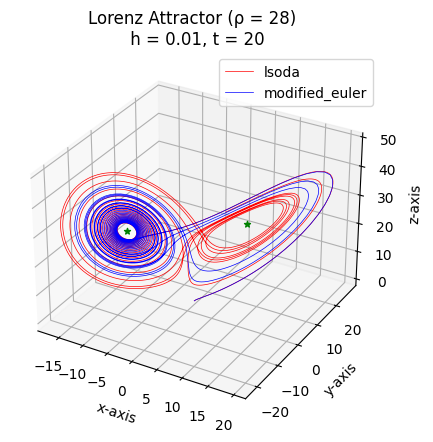

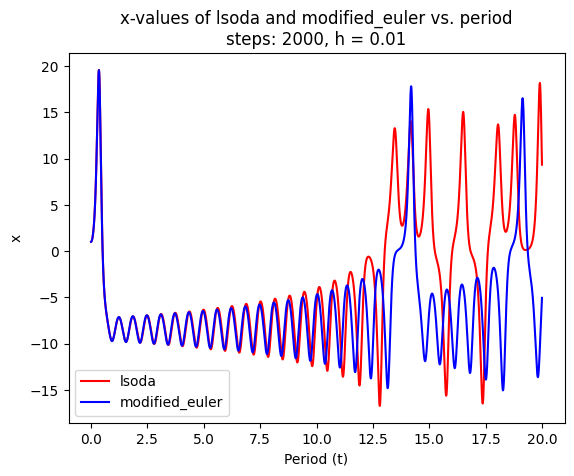

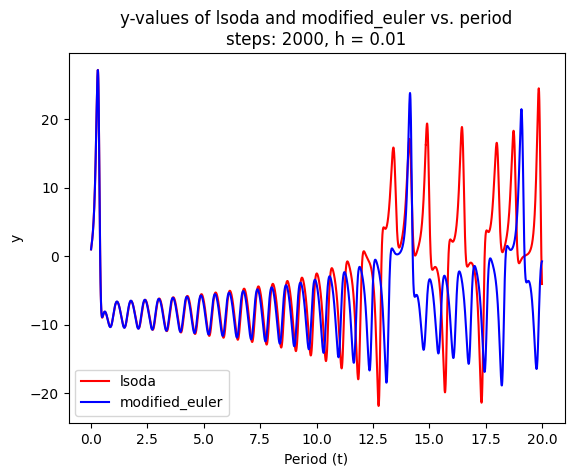

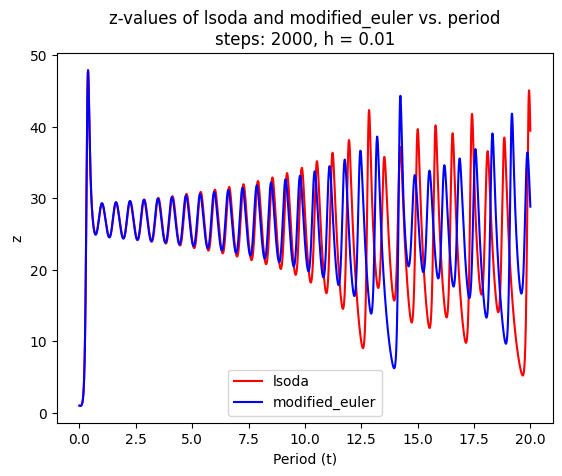

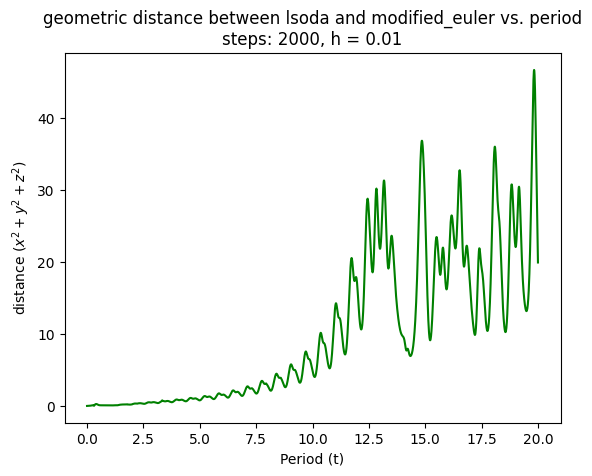

In [15]:
compare_lsoda_to_method(t = 20, h = 0.01, w0 = (1., 1., 1.), method = "modified_euler")

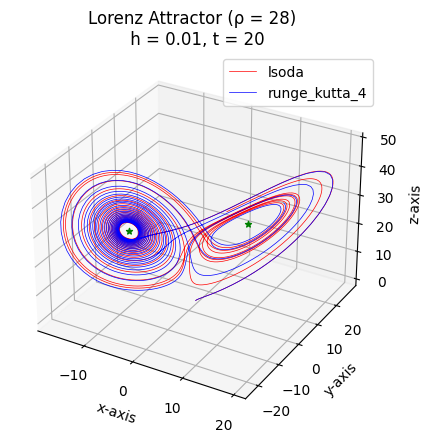

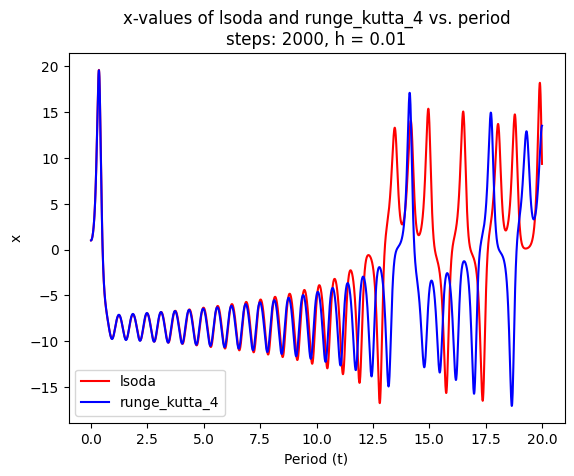

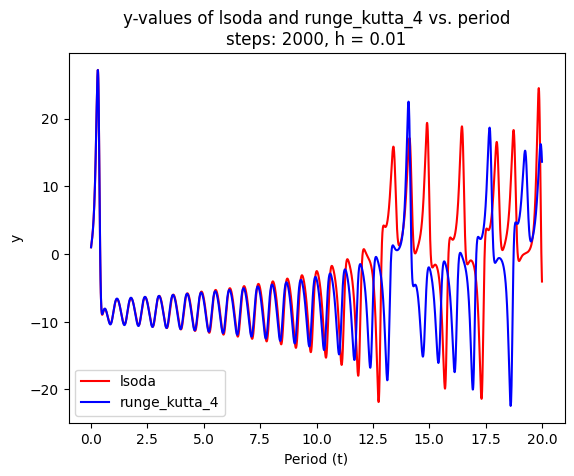

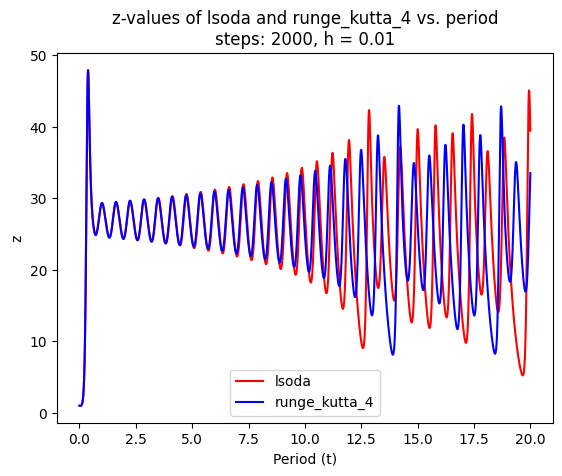

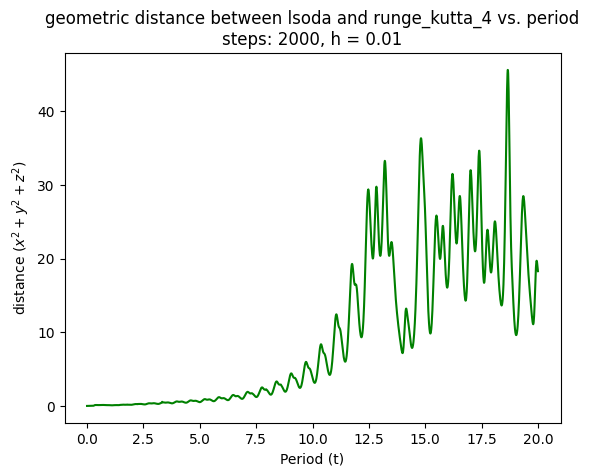

In [16]:
compare_lsoda_to_method(t = 20, h = 0.01, w0 = (1., 1., 1.), method = "runge_kutta_4")

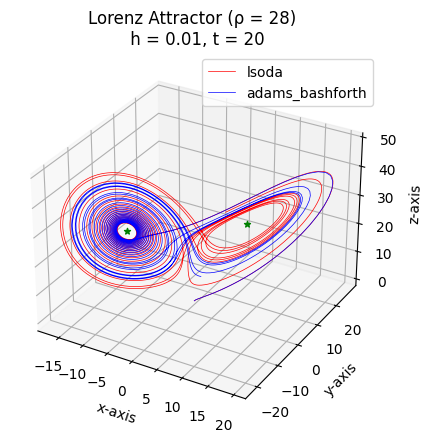

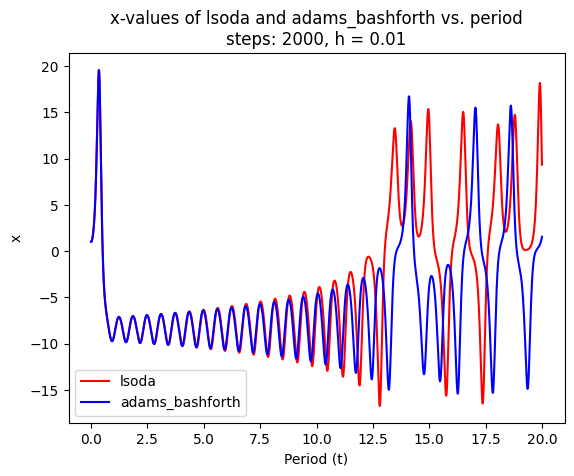

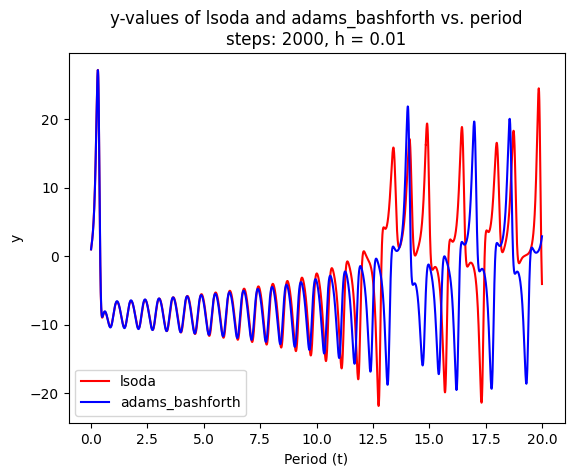

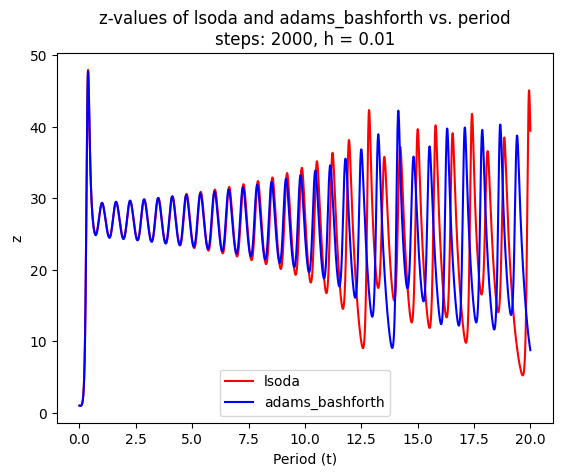

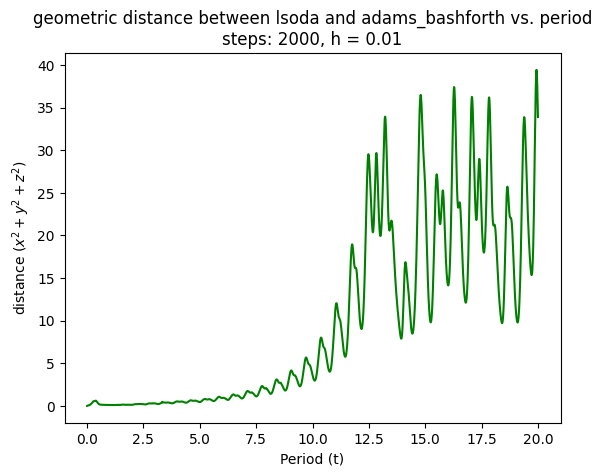

In [17]:
compare_lsoda_to_method(t = 20, h = 0.01, w0 = (1., 1., 1.), method = "adams_bashforth")

In [18]:
# This is for the beginning slides animation
# Note that the "key" param in plotLorenz is outdated, used as a hardcode to generate array skipping by 10
"""
# %matplotlib inline 
# %matplotlib ipympl
%matplotlib tk 

r = 28
s = 10
b = 8.0/3.0
plt.close()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Lorenz Attractor (ρ = 28)')

steps = 10000
stepSize = 0.01
lorenz0, func0 = plotLorenz((1., 1., 1.), steps, stepSize, ax, method = "euler", key = False, c= "red")
lorenz1, func1 = plotLorenz((1., 1., 1.), steps*10, stepSize/10, ax, method = "euler", key = True, c= "blue")

def update(num, func0, lorenz0, func1, lorenz1):
        func0.set_data(lorenz0[0:2, :num])
        func0.set_3d_properties(lorenz0[2, :num])
        func1.set_data(lorenz1[0:2, :num])
        func1.set_3d_properties(lorenz1[2, :num])

anim = FuncAnimation(fig, update, frames = steps, interval = 20, fargs = (func0, lorenz0, func1, lorenz1))

# plotting the fixed points
fp1 = (math.sqrt(b * (r-1)), math.sqrt(b * (r-1)), r-1)
fp2 = (-math.sqrt(b * (r-1)), -math.sqrt(b * (r-1)), r-1)

ax.scatter(fp1[0], fp1[1], fp1[2], marker='*', color = 'g')
ax.scatter(fp2[0], fp2[1], fp2[2], marker='*', color = 'g')

f = r"c://Users/ronki/Documents/CS Projects/MATH 104/Untitled Folder/anim.gif"
writergif = matplotlib.animation.PillowWriter(fps=30) 
anim.save(f, writer=writergif)"""

In [20]:
r = 28
s = 10
b = 8.0/3.0

refLorenz, refTime = getLorenz(w0 = (1., 1., 1.), t = 100, h = 1e-6, method='lsoda')

In [27]:
def method_match_runtime(expected_t, start_h, relativeError, method):
    hs = []
    periods = []
    times = []
    h = start_h
    while h > 1e-5:
        lorenz, t = getLorenz(w0 = (1., 1., 1.), t = expected_t, h = h, method=method)
        for i in range(shape(lorenz)[1]):
            if npla.norm(lorenz[:, i] - refLorenz[:, int(i*h*1e6)]) / npla.norm(refLorenz[:, int(i*h*1e6)]) > relativeError:
                hs.append(h)
                periods.append(h*i)
                times.append(t)
                break
        h -= 1e-4

    plt.title(f'{method} approximation match vs. h-values\nwithin relative error: {relativeError*100}%')
    plt.xlabel('h-value (step size)')
    plt.xscale("log") 
    plt.ylabel(r'period (from $t = 0$)')
    plt.plot(hs, periods)
    plt.show()
    
    plt.title(f'{method} approximation runtime vs. h-values')
    plt.xlabel('h-value (step size)')
    plt.xscale("log") 
    plt.ylabel('runtime (seconds)')
    plt.plot(hs, times)
    plt.show()
    
    return hs, periods, times

C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:14: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([s*(w[1] - w[0]), r*w[0] - w[1] - w[0]*w[2], w[0]*w[1] - b*w[2]])
C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([s*(w[1] - w[0]), r*w[0] - w[1] - w[0]*w[2], w[0]*w[1] - b*w[2]])
C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:19: RuntimeWarning: invalid value encountered in add
  data[:, i+1] = data[:, i] + lorenz(data[:, i]) * h


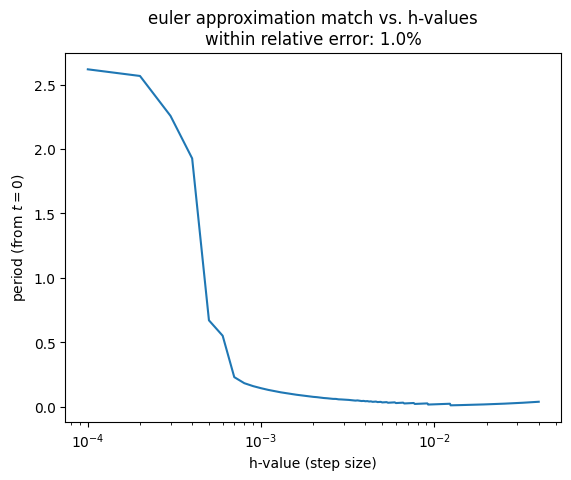

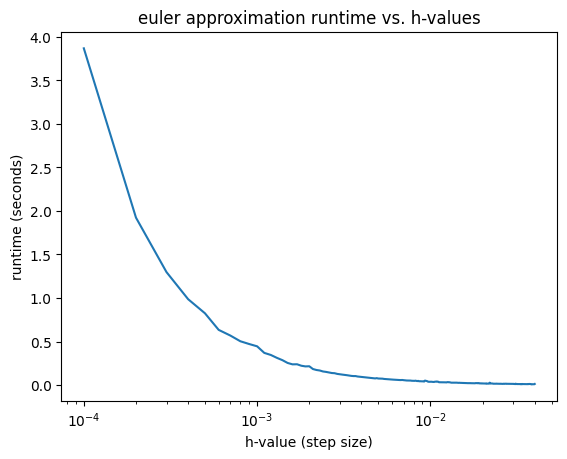

In [28]:
hs0, periods0, times0 = method_match_runtime(expected_t = 100, start_h = 0.04, relativeError = 0.01, method = "euler")

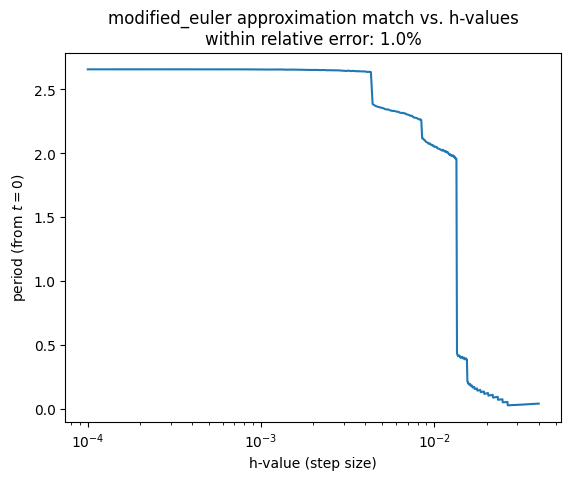

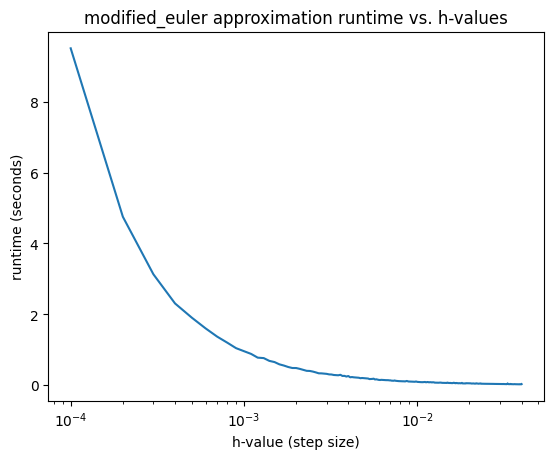

In [29]:
hs1, periods1, times1 = method_match_runtime(expected_t = 100, start_h = 0.04, relativeError = 0.01, method = "modified_euler")

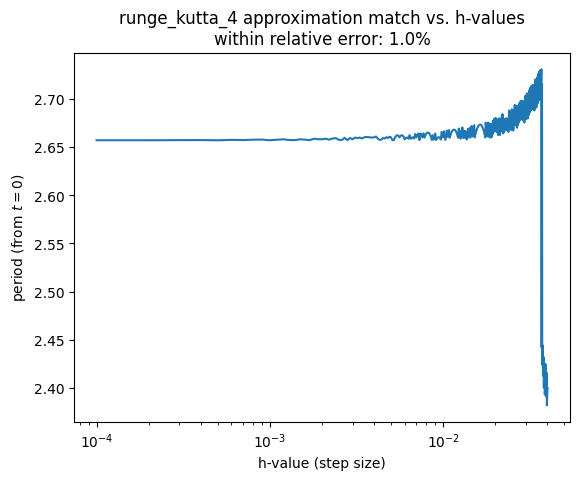

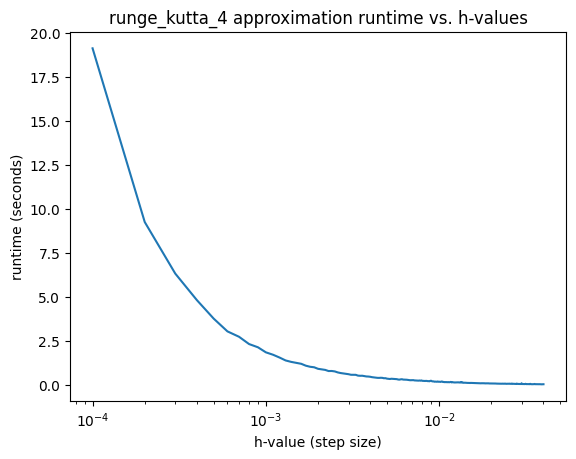

In [30]:
hs2, periods2, times2 = method_match_runtime(expected_t = 100, start_h = 0.04, relativeError = 0.01, method = "runge_kutta_4")

C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:14: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([s*(w[1] - w[0]), r*w[0] - w[1] - w[0]*w[2], w[0]*w[1] - b*w[2]])
C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([s*(w[1] - w[0]), r*w[0] - w[1] - w[0]*w[2], w[0]*w[1] - b*w[2]])
C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:41: RuntimeWarning: invalid value encountered in add
  data[:, i+1] = data[:, i] + h/24.0 * (55.0*lorenz(data[:, i]) - 59.0*lorenz(data[:, i-1]) + 37.0*lorenz(data[:, i-2]) - 9.0*lorenz(data[:, i-3]))
C:\Users\ronki\AppData\Local\Temp\ipykernel_17680\2579030641.py:41: RuntimeWarning: overflow encountered in multiply
  data[:, i+1] = data[:, i] + h/24.0 * (55.0*lorenz(data[:, i]) - 59.0*lorenz(data[:, i-1]) + 37.0*lorenz(data[:, i-2]) - 9.0*lorenz(data[:, i-3]))


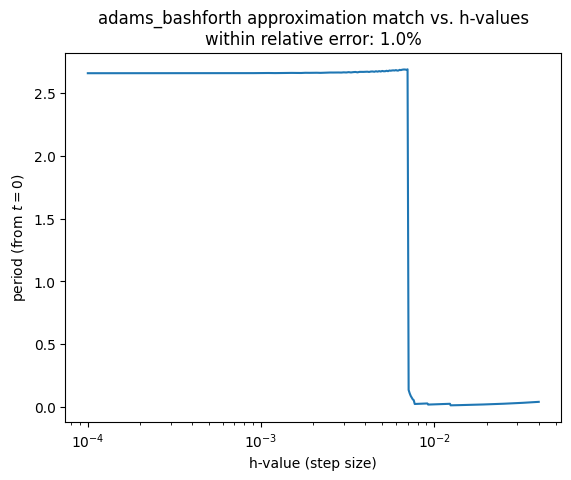

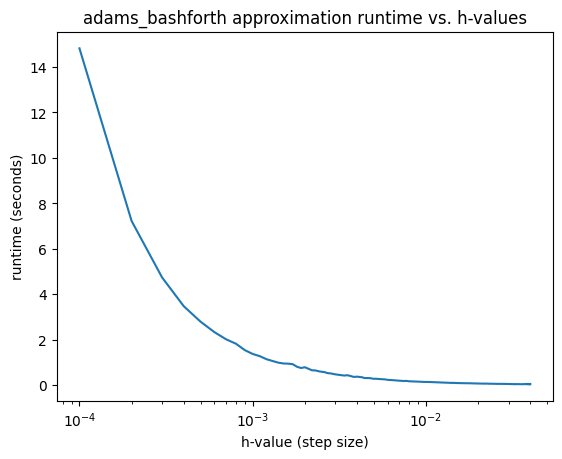

In [31]:
hs3, periods3, times3 = method_match_runtime(expected_t = 100, start_h = 0.04, relativeError = 0.01, method = "adams_bashforth")

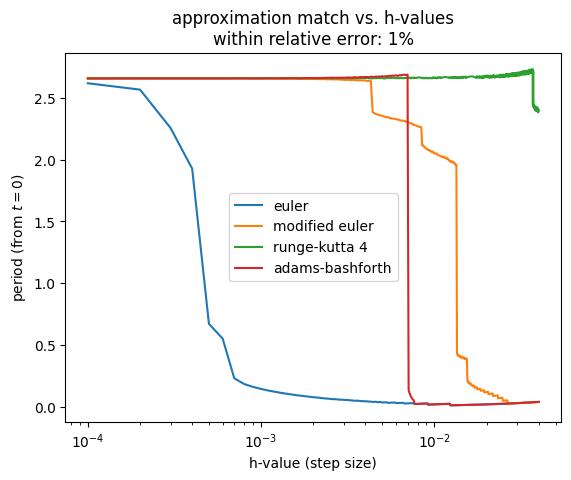

In [47]:
%matplotlib inline

plt.title(f'approximation match vs. h-values\nwithin relative error: 1%')
plt.xlabel('h-value (step size)')
plt.xscale("log") 
plt.ylabel(r'period (from $t= 0$)')
plt.plot(hs0, periods0, label = 'euler')
plt.plot(hs1, periods1, label = 'modified euler')
plt.plot(hs2, periods2, label = 'runge-kutta 4')
plt.plot(hs3, periods3, label = 'adams-bashforth')
plt.legend()
plt.show()

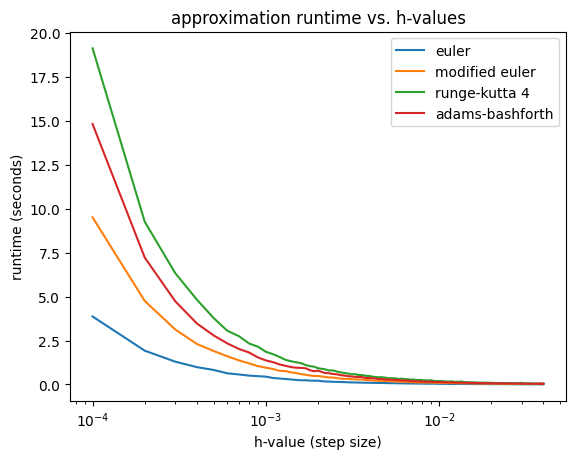

In [48]:
%matplotlib inline

plt.title(f'approximation runtime vs. h-values')
plt.xlabel('h-value (step size)')
plt.xscale("log") 
plt.ylabel('runtime (seconds)')
plt.plot(hs0, times0, label = 'euler')
plt.plot(hs1, times1, label = 'modified euler')
plt.plot(hs2, times2, label = 'runge-kutta 4')
plt.plot(hs3, times3, label = 'adams-bashforth')
plt.legend()
plt.show()